In [1]:
import sys
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from brownie import network
sys.path.append('../')

In [2]:
load_dotenv()
network.connect('optimism-main')

In [3]:
from modules.perp_protocol import Perp
from modules.univ3_modelling import UniswapV3

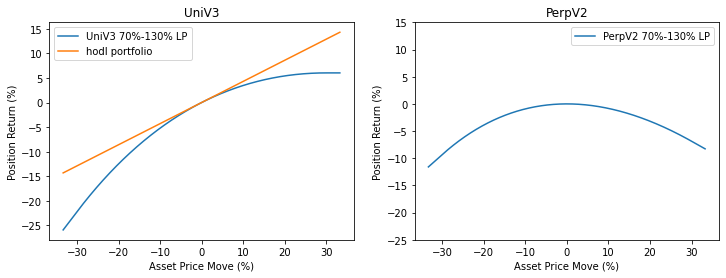

In [4]:
# UniV3 vs PerpV2 LPing

# lp initial parameters
lp_range = np.array([0.7,1.3])
liquidity_usd = 1000
spot_price = 1500

# initial position
lp_position = UniswapV3(liquidity_usd = liquidity_usd, initial_price = spot_price, price_barriers = lp_range*spot_price)

# create price range for plotting
p_min, p_max = 1000, 2000
price_range = np.arange(p_min, p_max, 1)


# Generating the position data for the whole price range
uni_v3_values = np.array([lp_position.position_value(price) for price in price_range])
perp_v2_values = np.array([lp_position.perp_v2_position_pnl(price) for price in price_range])
hodl_values = np.array([(lp_position.initial_quantity[0]*price+lp_position.initial_quantity[1]) for price in price_range])


# plot data
f = plt.figure(figsize=(12,4))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.plot((price_range/spot_price-1)*100, (uni_v3_values/liquidity_usd-1)*100,label='UniV3 70%-130% LP')
ax.plot((price_range/spot_price-1)*100, (hodl_values/liquidity_usd-1)*100, label = 'hodl portfolio')

ax.set_xlabel('Asset Price Move (%)')
ax.set_ylabel('Position Return (%)')
ax.set_title('UniV3')
ax.legend()
ax2.plot((price_range/spot_price-1)*100, (perp_v2_values/liquidity_usd)*100,label='PerpV2 70%-130% LP')
ax2.set_xlabel('Asset Price Move (%)')
ax2.set_ylabel('Position Return (%)')
ax2.set_ylim([-25,15])
ax2.set_title('PerpV2')
ax2.legend()
plt.show()

In [5]:
# initialise Perp Class and fetch onchain pool data
perp = Perp()
perp_pool_data = perp.pool_data.copy()

In [6]:
additional_columns = ['pool_share','daily_break_even%_old','daily_break_even%_new']

perp_pool_data[additional_columns] = 0 

# old reward amounts
perp_pool_data['weekly_reward_tokens_old'] = 5000

# new reward amounts
perp_pool_data['weekly_reward_tokens_new'] = 3000
perp_pool_data.loc[['vAAVE','vBNB','vBTC','vFLOW','vPERP'],'weekly_reward_tokens_new'] = 5000
perp_pool_data.loc['vETH','weekly_reward_tokens_new'] = 27000

op_price = 1.15
perp_price = 0.70

for i,row in perp_pool_data.iterrows():
    price = row.mark_price
        
    barrier_range = 0.5
    price_barriers = np.array([1-barrier_range, 1+barrier_range])*price
    
    v3_pos = UniswapV3(liquidity_usd = 1000, initial_price = price, price_barriers = price_barriers)
    
    pool_share = v3_pos.liquidity/(row.pool_liquidity+v3_pos.liquidity)
    
    dollar_gamma = v3_pos.position_value_gamma(price)*price**2/100
     
    daily_rewards_old = pool_share*row.weekly_reward_tokens_old*(op_price+perp_price)/7
    daily_rewards_new = pool_share*row.weekly_reward_tokens_new*(op_price+perp_price)/7
    
    breakeven_rewards_old = round(np.sqrt(daily_rewards_old/-dollar_gamma/100*2)*100,2)
    breakeven_rewards_new = round(np.sqrt(daily_rewards_new/-dollar_gamma/100*2)*100,2)
    

    perp_pool_data.loc[i,additional_columns] = np.round(np.array([pool_share,breakeven_rewards_old,
                                                             breakeven_rewards_new]),5)
    
    
perp_pool_data[['pool_tvl','weekly_reward_tokens_old','weekly_reward_tokens_new','daily_break_even%_old','daily_break_even%_new']]


,pool_tvl,weekly_reward_tokens_old,weekly_reward_tokens_new,daily_break_even%_old,daily_break_even%_new
vAAVE,7.927480e+05,5000,5000,4.63,4.63
vAPE,6.050645e+05,5000,3000,5.30,4.10
vATOM,7.121011e+05,5000,3000,4.55,3.52
vAVAX,5.876728e+05,5000,3000,4.72,3.66
vBNB,9.482321e+05,5000,5000,3.38,3.38
vBTC,3.427245e+06,5000,5000,2.26,2.26
vCRV,6.516891e+05,5000,3000,5.17,4.01
vETH,9.075485e+06,5000,27000,1.51,3.51
vFLOW,5.717945e+05,5000,5000,5.24,5.24
vFTM,5.715958e+05,5000,3000,5.25,4.07


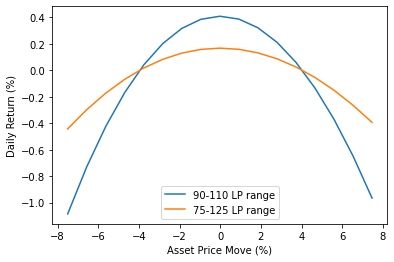

In [7]:
# effect of LP range on daily return profile
# use CRV

liquidity_usd = 1000
spot_price = perp_pool_data.loc['vCRV','index_price']

lp_range_1 = np.array([0.9,1.1])
lp_range_2 = np.array([0.75,1.25])


# positions
lp_position_1 = UniswapV3(liquidity_usd = liquidity_usd, initial_price = spot_price, price_barriers = lp_range_1*spot_price)
lp_position_2 = UniswapV3(liquidity_usd = liquidity_usd, initial_price = spot_price, price_barriers = lp_range_2*spot_price)


# create price range for plotting
p_min, p_max = 0.925*spot_price, 1.075*spot_price
price_range = np.arange(p_min, p_max, 0.01)


# Generating the position data for the whole price range
position_values_1 = np.array([lp_position_1.perp_v2_position_pnl(price) for price in price_range])
position_values_2 = np.array([lp_position_2.perp_v2_position_pnl(price) for price in price_range])

# daily rewards
daily_pool_reward = perp_pool_data.loc['vCRV','weekly_reward_tokens_new']*(op_price+perp_price)/7
pool_liquidity = perp_pool_data.loc['vCRV','pool_liquidity']
daily_reward_1 = lp_position_1.liquidity / (pool_liquidity+lp_position_1.liquidity)*daily_pool_reward
daily_reward_2 = lp_position_2.liquidity / (pool_liquidity+lp_position_2.liquidity)*daily_pool_reward

plt.plot((price_range/spot_price-1)*100,(position_values_1+daily_reward_1)/liquidity_usd*100,label='90-110 LP range')
plt.plot((price_range/spot_price-1)*100,(position_values_2+daily_reward_2)/liquidity_usd*100,label='75-125 LP range')
plt.xlabel('Asset Price Move (%)')
plt.ylabel('Daily Return (%)')
plt.legend()
plt.show()
